# Analysis of Paired Augmentation Performance on the BUSI Dataset

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tbparse import SummaryReader

INDIVIDUAL_EFFECTS_RESULTS = "../results/busi_individual_agg.csv"
LOG_DIR = "../tensorboard_logs/paired_effects/busi"

TRANSFORM_TO_YLABEL = {
    "brightness": "Brightness (1)",
    "contrast": "Contrast (2)",
    "elastic_transform": "Elastic (3)",
    "equalize": "Equalize (4)",
    "horizontal_flip": "Flip H. (5)",
    "vertical_flip": "Flip V. (6)",
    "gaussian_blur": "Gauss. blur (7)",
    "gaussian_noise": "Gauss. noise (8)",
    "grid_distortion": "Grid distort (9)",
    "median_blur": "Median blur (10)",
    "random_crop": "Random crop (11)",
    "rotation": "Rotate (12)",
    "saturation": "Saturation (13)",
    "scaling": "Scale (14)",
    "shear_x": "Shear X (15)",
    "shear_y": "Shear Y (16)",
    "translate_x": "Translate X (17)",
    "translate_y": "Translate Y (18)",
}

TRANSFORM_TO_XLABEL = {
    "brightness": 1,
    "contrast": 2,
    "elastic_transform": 3,
    "equalize": 4,
    "horizontal_flip": 5,
    "vertical_flip": 6,
    "gaussian_blur": 7,
    "gaussian_noise": 8,
    "grid_distortion": 9,
    "median_blur": 10,
    "random_crop": 11,
    "rotation": 12,
    "saturation": 13,
    "scaling": 14,
    "shear_x": 15,
    "shear_y": 16,
    "translate_x": 17,
    "translate_y": 18,
}

## Parse Tensorboard Logs

In [2]:
# NOTE: This cell only needs to be run once. Afterwards, the results can be loaded from the CSV file.

log_dirs = [f.path for f in os.scandir(LOG_DIR) if f.is_dir()]

results_df = None
for dir in log_dirs:
    operation1, operation2 = dir.split("/")[-1].split("-")
    reader = SummaryReader(dir, extra_columns={"wall_time", "dir_name"})

    df = reader.scalars
    df["wall_time"] = pd.to_datetime(df["wall_time"], unit="s")
    df[["split", "train_fold", "log_dir", "run"]] = df["dir_name"].str.split(
        pat="/", n=3, expand=True
    )
    df["split"] = df["split"].str.replace("split_", "").astype(int)
    df["train_fold"] = df["train_fold"].str.replace("trainfold_", "").astype(int)
    df["run"] = df["run"].str.replace("version_", "").astype(int)
    df = df.drop(columns=["log_dir"])
    df["operation1"] = operation1
    df["operation2"] = operation2

    summary_df = (
        df[df["tag"] == "val/bacc_epoch"][
            ["operation1", "operation2", "split", "train_fold", "run", "value"]
        ]
        .groupby(["operation1", "operation2", "split", "train_fold", "run"])
        .max("value")
        .reset_index()
    )
    summary_df = summary_df.rename(columns={"value": "bacc"})

    if results_df is None:
        results_df = summary_df
    else:
        results_df = pd.concat([results_df, summary_df])

results_df.to_csv("../results/busi_combined.csv", index=False)
results_df.head()

,operation1,operation2,split,train_fold,run,bacc
0,brightness,contrast,0,0,45327939,0.818939
1,brightness,contrast,0,1,45327939,0.815023
2,brightness,contrast,1,0,45327939,0.796493
3,brightness,contrast,1,1,45327939,0.828824
4,brightness,contrast,2,0,45327939,0.793765


## Aggregate Results

In [2]:
results_df = pd.read_csv("../results/busi_combined.csv")
results_df.head()

,operation1,operation2,split,train_fold,run,bacc
0,brightness,contrast,0,0,45327939,0.818939
1,brightness,contrast,0,1,45327939,0.815023
2,brightness,contrast,1,0,45327939,0.796493
3,brightness,contrast,1,1,45327939,0.828824
4,brightness,contrast,2,0,45327939,0.793765


In [3]:
# Calculate means
agg_results_df = (
    results_df.groupby(["operation1", "operation2", "split"])
    .mean()
    .reset_index()
    .drop(columns=["train_fold"])
)
agg_results_df = (
    agg_results_df.groupby(["operation1", "operation2"])
    .mean()
    .reset_index()
    .drop(columns=["split", "run"])
)
agg_results_df.sort_values("bacc").head()

,operation1,operation2,bacc
104,grid_distortion,elastic_transform,0.728178
39,elastic_transform,grid_distortion,0.739639
70,gaussian_blur,elastic_transform,0.754411
44,elastic_transform,saturation,0.764667
189,saturation,elastic_transform,0.765581


In [4]:
# Calculate difference vs. baselines
baselines_df = pd.read_csv(INDIVIDUAL_EFFECTS_RESULTS)
agg_results_df["bacc_no_aug"] = baselines_df[
    baselines_df["transform"] == "center_crop"
]["bacc"].values[0]
agg_results_df = pd.merge(
    agg_results_df,
    baselines_df[["transform", "bacc"]],
    left_on="operation1",
    right_on="transform",
)
agg_results_df.rename(
    columns={"bacc_x": "bacc", "bacc_y": "bacc_operation1"}, inplace=True
)
agg_results_df["diff_no_aug"] = agg_results_df["bacc"] - agg_results_df["bacc_no_aug"]
agg_results_df["diff_operation1"] = (
    agg_results_df["bacc"] - agg_results_df["bacc_operation1"]
)

agg_results_df.to_csv("../results/busi_combined_agg.csv", index=False)
agg_results_df.head()

,operation1,operation2,bacc,bacc_no_aug,transform,bacc_operation1,diff_no_aug,diff_operation1
0,brightness,contrast,0.818095,0.789712,brightness,0.816034,0.028384,0.002061
1,brightness,elastic_transform,0.806892,0.789712,brightness,0.816034,0.017180,-0.009143
2,brightness,equalize,0.809592,0.789712,brightness,0.816034,0.019880,-0.006443
3,brightness,gaussian_blur,0.813638,0.789712,brightness,0.816034,0.023926,-0.002396
4,brightness,gaussian_noise,0.832370,0.789712,brightness,0.816034,0.042658,0.016336


## Visualize Results

### Mean Performance

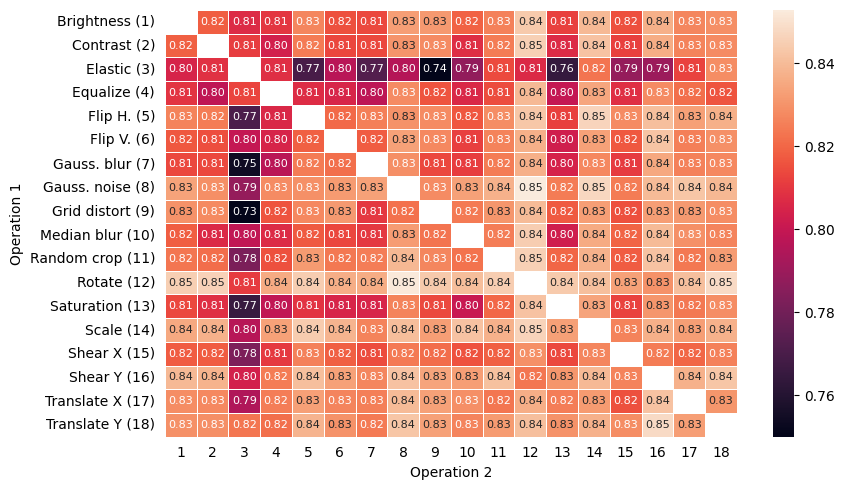

In [5]:
fig = plt.figure(figsize=(9, 5))

plot_df = agg_results_df.copy()
plot_df["operation1"] = plot_df["operation1"].map(TRANSFORM_TO_YLABEL)
plot_df["operation2"] = plot_df["operation2"].map(TRANSFORM_TO_XLABEL)

ax = sns.heatmap(
    plot_df.pivot(index="operation1", columns="operation2", values="bacc"),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    vmin=0.75,
    annot_kws={"size": 8},
)

# Axes
ax.tick_params(left=False, bottom=False)
ax.set_ylabel("Operation 1")
ax.set_xlabel("Operation 2")


plt.tight_layout()
plt.savefig("../results/busi_combined_bacc.pdf", bbox_inches="tight")
plt.show()

### Mean Improvement over no Augmentation

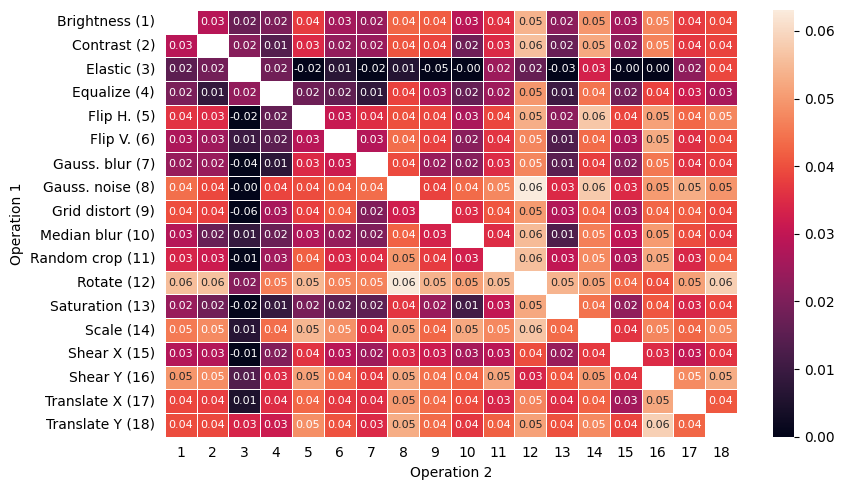

In [6]:
fig = plt.figure(figsize=(9, 5))

plot_df = agg_results_df.copy()
plot_df["operation1"] = plot_df["operation1"].map(TRANSFORM_TO_YLABEL)
plot_df["operation2"] = plot_df["operation2"].map(TRANSFORM_TO_XLABEL)

ax = sns.heatmap(
    plot_df.pivot(index="operation1", columns="operation2", values="diff_no_aug"),
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    vmin=0.0,
    annot_kws={"size": 8},
)

# Axes
ax.tick_params(left=False, bottom=False)
ax.set_ylabel("Operation 1")
ax.set_xlabel("Operation 2")

plt.tight_layout()
plt.savefig("../results/busi_combined_diff_no_aug.pdf", bbox_inches="tight")
plt.show()

### Mean Improvement over Applying a Single Augmentation

The performance improvement from applying the second operation after the first.

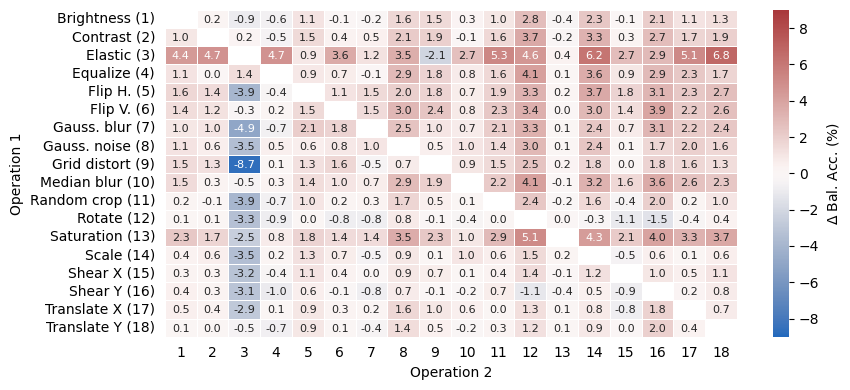

In [15]:
fig = plt.figure(figsize=(9, 4.0))

plot_df = agg_results_df.copy()
plot_df["operation1"] = plot_df["operation1"].map(TRANSFORM_TO_YLABEL)
plot_df["operation2"] = plot_df["operation2"].map(TRANSFORM_TO_XLABEL)
plot_df["diff_operation1"] = plot_df["diff_operation1"] * 100

ax = sns.heatmap(
    plot_df.pivot(index="operation1", columns="operation2", values="diff_operation1"),
    annot=True,
    fmt="z.1f",
    linewidth=0.5,
    vmin=-9,
    vmax=9,
    annot_kws={"size": 8, "va": "center_baseline"},
    cmap="vlag",
    cbar_kws={"label": "$\Delta$ Bal. Acc. (%)"},
)

# Axes
ax.tick_params(left=False, bottom=False)
ax.set_ylabel("Operation 1")
ax.set_xlabel("Operation 2")

plt.tight_layout()
plt.savefig("../results/busi_combined_diff_op1.pdf", bbox_inches="tight")
plt.show()